<a href="https://colab.research.google.com/github/umbertogagl97/Tesi/blob/main/Impronte/AttaccoScanner/Attacco_PGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Init**

##Import ART

In [1]:
#importa ART
!pip install adversarial-robustness-toolbox

     |████████████████████████████████| 1.1 MB 9.1 MB/s 
     |████████████████████████████████| 3.3 MB 61.1 MB/s 
     |████████████████████████████████| 26.3 MB 1.2 MB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2


## Import librerie

In [2]:
#Librerie

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
#import time
#import os
#import shutil
#import copy

import pandas as pd
import matplotlib.pyplot as plt
import sys


##Check device


In [3]:
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

1.9.0+cu111
True
Tesla P100-PCIE-16GB
cuda:0


##Transforms

In [98]:
from torchvision.transforms.functional import InterpolationMode
transf_init=transforms.Resize(size=(1000,1000),interpolation=InterpolationMode.NEAREST)

##Def path

In [5]:
#scanner
scanner_name = 'HiScan'

#salvataggio modello
model_name = 'VGG19_10epoc_lr5_bs200_adam'
path_model = F"/content/gdrive/My Drive/ModelliCNN/Scanner/{scanner_name}/{model_name}" 

#dataset
pathTestset=F'/content/gdrive/MyDrive/Dataset_impronte/test/{scanner_name}'

pd_preds_value=F'/content/gdrive/MyDrive/Dataset_impronte/test/Preds_value/{scanner_name}.xlsx'

data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

##Collegamento google drive

In [6]:
#collegamento google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#**Dataset**

##Caricamento dataset

In [127]:
test_dataset = datasets.ImageFolder(pathTestset,transforms.ToTensor())
dim_set=len(test_dataset)
print(dim_set)

2500


##Dataloader

In [128]:
testgen=torch.utils.data.DataLoader(test_dataset, pin_memory=True, batch_size=1,num_workers=2)
print(len(testgen))

2500


##Nomi classi

In [129]:
classes_name=test_dataset.classes
class_number=len(classes_name)
print(classes_name)
print(class_number)
#del test_dataset

['Live', 'Spoof']
2


#**Riduzione dataset**

In [28]:
test_dataset.samples=test_dataset.samples[997:1002]
test_dataset.targets=test_dataset.targets[997:1002]

dim_set=len(test_dataset)
print(dim_set)

5


# **Creazione modello**

> non ho bloccato i parametri inferiori e sbloccato quelli del classificatore, vedi se funziona



##Load model pre-trained

In [11]:
model = models.vgg19(pretrained=True,progress=True)
#model = models.densenet201(pretrained=True,progress=True)
#print(model)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

##Aggiunta classificatore

In [12]:
model.classifier[6]=nn.Linear(4096,2) #per vgg19
#model.classifier=nn.Linear(1920,2) #per densenet201

#print(model) 

##Load pesi

In [13]:
model.load_state_dict(torch.load(path_model))#,map_location=torch.device('cpu')))


<All keys matched successfully>

# **Def funzioni**

##calc size

In [14]:
def calc_size(n):
  '''
  n: int 
  return: 80% of n
  '''
  return tuple(int(np.ceil(i * (80/100))) for i in n)

##Testing

con media senza datframe

In [15]:
def test_average_preds(classifier,test_loader,):
  '''
  model: model trained
  test_loader: dataloader 
  return: dataframe{n_img,class_predicted,class_real}
  '''
  preds=[]
  #value=[]
  prob=nn.Softmax()
  data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
  i=0
  for input,label in test_loader:
    i+=1
    input=transf_init(input) #resize 1000
    n=input.shape
    n_mod=calc_size(n[2:4])
    crop_transform=transforms.TenCrop((n_mod[0],n_mod[1]))
    crops=crop_transform(input)
    live=0
    spoof=0
    for crop in crops:
      crop=data_transform_test(crop) #resize 224
      outputs = classifier.predict(crop)
      live+=outputs[0][0]
      spoof+=outputs[0][1]
    live=live/10
    spoof=spoof/10
    predicted=np.argmax([live,spoof])
    preds.append(predicted)
    #value.append(np.max(prob(torch.Tensor([live,spoof])).numpy()))
    value=np.max(prob(torch.Tensor([live,spoof])).numpy())

  return np.array(preds),value

##Array to dataloader

In [16]:
from torch.utils.data import TensorDataset, DataLoader

def array2dataloader(x,y):
  '''
  :param x: ndarray x_test;
  :param y: labels with two value
  '''
  tensor_x = torch.Tensor(x) # transform to torch tensor
  tensor_y = torch.Tensor(np.argmax(y,axis=1))

  my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
  return DataLoader(my_dataset) 

##APGD mod

In [125]:
import logging
import math
from typing import Optional, Union, TYPE_CHECKING

import numpy as np
from tqdm.auto import trange

from art.config import ART_NUMPY_DTYPE
from art.attacks.attack import EvasionAttack
from art.estimators.estimator import BaseEstimator, LossGradientsMixin
from art.estimators.classification.classifier import ClassifierMixin
from art.utils import check_and_transform_label_format, projection, random_sphere, is_probability, get_labels_np_array

if TYPE_CHECKING:
    from art.utils import CLASSIFIER_LOSS_GRADIENTS_TYPE

logger = logging.getLogger(__name__)


class AutoProjectedGradientDescent_mod(EvasionAttack):
    """
    Implementation of the `Auto Projected Gradient Descent` attack.
    | Paper link: https://arxiv.org/abs/2003.01690
    """

    attack_params = EvasionAttack.attack_params + [
        "norm",
        "eps",
        "eps_step",
        "max_iter",
        "targeted",
        "nb_random_init",
        "batch_size",
        "loss_type",
        "verbose",
    ]
    _estimator_requirements = (BaseEstimator, LossGradientsMixin, ClassifierMixin)
    _predefined_losses = [None, "cross_entropy", "difference_logits_ratio"]

    def __init__(
        self,
        estimator: "CLASSIFIER_LOSS_GRADIENTS_TYPE",
        norm: Union[int, float, str] = np.inf,
        eps: float = 0.3,
        eps_step: float = 0.1,
        max_iter: int = 100,
        targeted: bool = False,
        nb_random_init: int = 5,
        batch_size: int = 32,
        loss_type: Optional[str] = None,
        verbose: bool = True,
    ):
        """
        Create a :class:`.AutoProjectedGradientDescent` instance.
        :param estimator: An trained estimator.
        :param norm: The norm of the adversarial perturbation. Possible values: "inf", np.inf, 1 or 2.
        :param eps: Maximum perturbation that the attacker can introduce.
        :param eps_step: Attack step size (input variation) at each iteration.
        :param max_iter: The maximum number of iterations.
        :param targeted: Indicates whether the attack is targeted (True) or untargeted (False).
        :param nb_random_init: Number of random initialisations within the epsilon ball. For num_random_init=0
            starting at the original input.
        :param batch_size: Size of the batch on which adversarial samples are generated.
        :param loss_type: Defines the loss to attack. Available options: None (Use loss defined by estimator),
            "cross_entropy", or "difference_logits_ratio"
        :param verbose: Show progress bars.
        """
        from art.estimators.classification import TensorFlowClassifier, TensorFlowV2Classifier, PyTorchClassifier

        if loss_type not in self._predefined_losses:
            raise ValueError(
                "The argument loss_type has an invalid value. The following options for `loss_type` are currently "
                "supported: {}".format(self._predefined_losses)
            )

        if loss_type is None:
            if hasattr(estimator, "predict") and is_probability(
                estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=np.float32))
            ):
                raise ValueError(
                    "AutoProjectedGradientDescent is expecting logits as estimator output, the provided "
                    "estimator seems to predict probabilities."
                )

            estimator_apgd = estimator
        else:
            if isinstance(estimator, TensorFlowClassifier):
                import tensorflow as tf

                if loss_type == "cross_entropy":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise NotImplementedError("Cross-entropy loss is not implemented for probability output.")

                    self._loss_object = tf.reduce_mean(
                        tf.keras.losses.categorical_crossentropy(
                            y_pred=estimator._output, y_true=estimator._labels_ph, from_logits=True
                        )
                    )

                elif loss_type == "difference_logits_ratio":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    raise ValueError(
                        "The loss `difference_logits_ratio` has not been validate completely. It seems that the "
                        "commented implemented below is failing to selected the second largest logit for cases "
                        "where the largest logit is the true logit. For future work `difference_logits_ratio` and "
                        "loss_fn should return the same loss value."
                    )

                    # def difference_logits_ratio(y_true, y_pred):
                    #     i_y_true = tf.cast(tf.math.argmax(tf.cast(y_true, tf.int32), axis=1), tf.int32)
                    #     i_y_pred_arg = tf.argsort(y_pred, axis=1)
                    #     # Not completely sure if the following line is correct.
                    #     # `i_y_pred_arg[:, -2], i_y_pred_arg[:, -1]` seems closer to the output of `loss_fn` than
                    #     # `i_y_pred_arg[:, -1], i_y_pred_arg[:, -2]`
                    #     i_z_i = tf.where(i_y_pred_arg[:, -1] != i_y_true[:], i_y_pred_arg[:, -2],
                    #                      i_y_pred_arg[:, -1])
                    #
                    #     z_1 = tf.gather(y_pred, i_y_pred_arg[:, -1], axis=1, batch_dims=0)
                    #     z_3 = tf.gather(y_pred, i_y_pred_arg[:, -3], axis=1, batch_dims=0)
                    #     z_i = tf.gather(y_pred, i_z_i, axis=1, batch_dims=0)
                    #     z_y = tf.gather(y_pred, i_y_true, axis=1, batch_dims=0)
                    #
                    #     z_1 = tf.linalg.diag_part(z_1)
                    #     z_3 = tf.linalg.diag_part(z_3)
                    #     z_i = tf.linalg.diag_part(z_i)
                    #     z_y = tf.linalg.diag_part(z_y)
                    #
                    #     dlr = -(z_y - z_i) / (z_1 - z_3)
                    #
                    #     return tf.reduce_mean(dlr)
                    #
                    # def loss_fn(y_true, y_pred):
                    #     i_y_true = np.argmax(y_true, axis=1)
                    #     i_y_pred_arg = np.argsort(y_pred, axis=1)
                    #     i_z_i = np.where(i_y_pred_arg[:, -1] != i_y_true[:], i_y_pred_arg[:, -1],
                    #                      i_y_pred_arg[:, -2])
                    #
                    #     z_1 = y_pred[:, i_y_pred_arg[:, -1]]
                    #     z_3 = y_pred[:, i_y_pred_arg[:, -3]]
                    #     z_i = y_pred[:, i_z_i]
                    #     z_y = y_pred[:, i_y_true]
                    #
                    #     z_1 = np.diag(z_1)
                    #     z_3 = np.diag(z_3)
                    #     z_i = np.diag(z_i)
                    #     z_y = np.diag(z_y)
                    #
                    #     dlr = -(z_y - z_i) / (z_1 - z_3)
                    #
                    #     return np.mean(dlr)
                    #
                    # self._loss_fn = loss_fn
                    # self._loss_object = difference_logits_ratio(y_true=estimator._labels_ph,
                    #                                             y_pred=estimator._output)

                estimator_apgd = TensorFlowClassifier(
                    input_ph=estimator._input_ph,
                    output=estimator._output,
                    labels_ph=estimator._labels_ph,
                    train=estimator._train,
                    loss=self._loss_object,
                    learning=estimator._learning,
                    sess=estimator._sess,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                    feed_dict=estimator._feed_dict,
                )

            elif isinstance(estimator, TensorFlowV2Classifier):
                import tensorflow as tf

                if loss_type == "cross_entropy":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        self._loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
                    else:
                        self._loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
                elif loss_type == "difference_logits_ratio":
                    if is_probability(estimator.predict(x=np.ones(shape=(1, *estimator.input_shape)))):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    class DifferenceLogitsRatioTensorFlowV2:
                        """
                        Callable class for Difference Logits Ratio loss in TensorFlow v2.
                        """

                        def __init__(self):
                            self.reduction = "mean"

                        def __call__(self, y_true, y_pred):
                            i_y_true = tf.cast(tf.math.argmax(tf.cast(y_true, tf.int32), axis=1), tf.int32)
                            i_y_pred_arg = tf.argsort(y_pred, axis=1)
                            i_z_i_list = list()

                            for i in range(y_true.shape[0]):
                                if i_y_pred_arg[i, -1] != i_y_true[i]:
                                    i_z_i_list.append(i_y_pred_arg[i, -1])
                                else:
                                    i_z_i_list.append(i_y_pred_arg[i, -2])

                            i_z_i = tf.stack(i_z_i_list)

                            z_1 = tf.gather(y_pred, i_y_pred_arg[:, -1], axis=1, batch_dims=0)
                            z_3 = tf.gather(y_pred, i_y_pred_arg[:, -3], axis=1, batch_dims=0)
                            z_i = tf.gather(y_pred, i_z_i, axis=1, batch_dims=0)
                            z_y = tf.gather(y_pred, i_y_true, axis=1, batch_dims=0)

                            z_1 = tf.linalg.diag_part(z_1)
                            z_3 = tf.linalg.diag_part(z_3)
                            z_i = tf.linalg.diag_part(z_i)
                            z_y = tf.linalg.diag_part(z_y)

                            dlr = -(z_y - z_i) / (z_1 - z_3)

                            return tf.reduce_mean(dlr)

                    self._loss_fn = DifferenceLogitsRatioTensorFlowV2()
                    self._loss_object = DifferenceLogitsRatioTensorFlowV2()

                estimator_apgd = TensorFlowV2Classifier(
                    model=estimator.model,
                    nb_classes=estimator.nb_classes,
                    input_shape=estimator.input_shape,
                    loss_object=self._loss_object,
                    train_step=estimator._train_step,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                )
            elif isinstance(estimator, PyTorchClassifier):
                import torch

                if loss_type == "cross_entropy":
                    if is_probability(
                        estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=np.float32))
                    ):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. If loss_type='cross_entropy' "
                            "the estimator has to to predict logits."
                        )

                    self._loss_object = torch.nn.CrossEntropyLoss(reduction="mean")
                elif loss_type == "difference_logits_ratio":
                    if is_probability(
                        estimator.predict(x=np.ones(shape=(1, *estimator.input_shape), dtype=ART_NUMPY_DTYPE))
                    ):
                        raise ValueError(
                            "The provided estimator seems to predict probabilities. "
                            "If loss_type='difference_logits_ratio' the estimator has to to predict logits."
                        )

                    class DifferenceLogitsRatioPyTorch:
                        """
                        Callable class for Difference Logits Ratio loss in PyTorch.
                        """

                        def __init__(self):
                            self.reduction = "mean"

                        def __call__(self, y_pred, y_true):  # type: ignore
                            if isinstance(y_true, np.ndarray):
                                y_true = torch.from_numpy(y_true)
                            if isinstance(y_pred, np.ndarray):
                                y_pred = torch.from_numpy(y_pred)

                            y_true = y_true.float()

                            i_y_true = torch.argmax(y_true, axis=1)
                            i_y_pred_arg = torch.argsort(y_pred, axis=1)
                            i_z_i_list = list()

                            for i in range(y_true.shape[0]):
                                if i_y_pred_arg[i, -1] != i_y_true[i]:
                                    i_z_i_list.append(i_y_pred_arg[i, -1])
                                else:
                                    i_z_i_list.append(i_y_pred_arg[i, -2])

                            i_z_i = torch.stack(i_z_i_list)

                            z_1 = y_pred[:, i_y_pred_arg[:, -1]]
                            z_3 = y_pred[:, i_y_pred_arg[:, -3]]
                            z_i = y_pred[:, i_z_i]
                            z_y = y_pred[:, i_y_true]

                            z_1 = torch.diagonal(z_1)
                            z_3 = torch.diagonal(z_3)
                            z_i = torch.diagonal(z_i)
                            z_y = torch.diagonal(z_y)

                            dlr = -(z_y - z_i) / (z_1 - z_3)

                            return torch.mean(dlr.float())

                    self._loss_object = DifferenceLogitsRatioPyTorch()

                estimator_apgd = PyTorchClassifier(
                    model=estimator.model,
                    loss=self._loss_object,
                    input_shape=estimator.input_shape,
                    nb_classes=estimator.nb_classes,
                    optimizer=None,
                    channels_first=estimator.channels_first,
                    clip_values=estimator.clip_values,
                    preprocessing_defences=estimator.preprocessing_defences,
                    postprocessing_defences=estimator.postprocessing_defences,
                    preprocessing=estimator.preprocessing,
                    device_type=str(estimator._device),
                )

            else:
                raise ValueError("The loss type {} is not supported for the provided estimator.".format(loss_type))

        super().__init__(estimator=estimator_apgd)
        self.norm = norm
        self.eps = eps
        self.eps_step = eps_step
        self.max_iter = max_iter
        self.targeted = targeted
        self.nb_random_init = nb_random_init
        self.batch_size = batch_size
        self.loss_type = loss_type
        self.verbose = verbose
        self._check_params()

    def generate(self, x: np.ndarray, y: Optional[np.ndarray] = None, class_target=0, confidence=0.6, **kwargs) -> np.ndarray:
        """
        Generate adversarial samples and return them in an array.
        :param x: An array with the original inputs.
        :param y: Target values (class labels) one-hot-encoded of shape `(nb_samples, nb_classes)` or indices of shape
                  (nb_samples,). Only provide this parameter if you'd like to use true labels when crafting adversarial
                  samples. Otherwise, model predictions are used as labels to avoid the "label leaking" effect
                  (explained in this paper: https://arxiv.org/abs/1611.01236). Default is `None`.
        :param mask: An array with a mask broadcastable to input `x` defining where to apply adversarial perturbations.
                     Shape needs to be broadcastable to the shape of x and can also be of the same shape as `x`. Any
                     features for which the mask is zero will not be adversarially perturbed.
        :type mask: `np.ndarray`
        :return: An array holding the adversarial examples.
        """
        mask = kwargs.get("mask")

        y = check_and_transform_label_format(y, self.estimator.nb_classes)

        if y is None:
            if self.targeted:
                raise ValueError("Target labels `y` need to be provided for a targeted attack.")
            y = get_labels_np_array(self.estimator.predict(x, batch_size=self.batch_size)).astype(np.int32)

        if self.estimator.nb_classes == 2 and y.shape[1] == 1:
            raise ValueError(
                "This attack has not yet been tested for binary classification with a single output classifier."
            )

        x_adv = x.astype(ART_NUMPY_DTYPE)
        
        for _ in trange(max(1, self.nb_random_init), desc="AutoPGD - restart", disable=not self.verbose):
            
            # Determine correctly predicted samples
            #y_pred = self.estimator.predict(x_adv)
            
            preds,value=test_average_preds(self.estimator,array2dataloader(x_adv,y)) #preds è già la classe finale mentre y_pred contiene i due valori
            
            if self.targeted:
                sample_is_robust = np.argmax(y_pred, axis=1) != np.argmax(y, axis=1)
            elif not self.targeted:
                #sample_is_robust = np.argmax(y_pred, axis=1) == np.argmax(y, axis=1)
                if ((preds==np.argmax(y, axis=1)) and (preds!= class_target)):
                  sample_is_robust=True
                elif ((preds!=np.argmax(y, axis=1)) and (preds== class_target) and (value<confidence)):  
                  sample_is_robust=True
                else:  sample_is_robust=False

                #print("preds=label e preds=spoof")
              
              
                #print("preds=label, preds=live e confidence<0.6")
                
              

            #sample_is_robust è vettore di booleani, indica se l'attacco deve essere eseguito (True), ovvero se il modello predice bene
            
            #print("y: "+str(y))
            #print("pred: "+str(preds))
            #print("sampleisrobust: "+str(sample_is_robust))
            
            if sample_is_robust == False:
                break
            
            x_robust = x_adv
            y_robust = y
            x_init = x
            
            n = x_robust.shape[0]
            m = np.prod(x_robust.shape[1:]).item()
            random_perturbation = (
                random_sphere(n, m, self.eps, self.norm).reshape(x_robust.shape).astype(ART_NUMPY_DTYPE)
            )

            x_robust = x_robust + random_perturbation

            if self.estimator.clip_values is not None:
                clip_min, clip_max = self.estimator.clip_values
                x_robust = np.clip(x_robust, clip_min, clip_max)

            perturbation = projection(x_robust - x_init, self.eps, self.norm)
            x_robust = x_init + perturbation

            # Compute perturbation with implicit batching
            for batch_id in trange(
                int(np.ceil(x_robust.shape[0] / float(self.batch_size))),
                desc="AutoPGD - batch",
                leave=False,
                disable=not self.verbose,
            ):
                self.eta = 2 * self.eps_step
                batch_index_1, batch_index_2 = batch_id * self.batch_size, (batch_id + 1) * self.batch_size
                x_k = x_robust[batch_index_1:batch_index_2].astype(ART_NUMPY_DTYPE)
                x_init_batch = x_init[batch_index_1:batch_index_2].astype(ART_NUMPY_DTYPE)
                y_batch = y_robust[batch_index_1:batch_index_2]

                p_0 = 0
                p_1 = 0.22
                var_w = [p_0, p_1]

                while True:
                    p_j_p_1 = var_w[-1] + max(var_w[-1] - var_w[-2] - 0.03, 0.06)
                    if p_j_p_1 > 1:
                        break
                    var_w.append(p_j_p_1)

                var_w = [math.ceil(p * self.max_iter) for p in var_w]

                eta = self.eps_step
                self.count_condition_1 = 0

                for k_iter in trange(self.max_iter, desc="AutoPGD - iteration", leave=False, disable=not self.verbose):

                    # Get perturbation, use small scalar to avoid division by 0
                    tol = 10e-8

                    # Get gradient wrt loss; invert it if attack is targeted
                    grad = self.estimator.loss_gradient(x_k, y_batch) * (1 - 2 * int(self.targeted))

                    # Apply norm bound
                    if self.norm in [np.inf, "inf"]:
                        grad = np.sign(grad)
                    elif self.norm == 1:
                        ind = tuple(range(1, len(x_k.shape)))
                        grad = grad / (np.sum(np.abs(grad), axis=ind, keepdims=True) + tol)
                    elif self.norm == 2:
                        ind = tuple(range(1, len(x_k.shape)))
                        grad = grad / (np.sqrt(np.sum(np.square(grad), axis=ind, keepdims=True)) + tol)
                    assert x_k.shape == grad.shape

                    perturbation = grad

                    if mask is not None:
                        perturbation = perturbation * (mask.astype(ART_NUMPY_DTYPE))

                    # Apply perturbation and clip
                    z_k_p_1 = x_k + eta * perturbation

                    if self.estimator.clip_values is not None:
                        clip_min, clip_max = self.estimator.clip_values
                        z_k_p_1 = np.clip(z_k_p_1, clip_min, clip_max)

                    if k_iter == 0:
                        x_1 = z_k_p_1
                        perturbation = projection(x_1 - x_init_batch, self.eps, self.norm)
                        x_1 = x_init_batch + perturbation

                        f_0 = self.estimator.compute_loss(x=x_k, y=y_batch, reduction="mean")
                        f_1 = self.estimator.compute_loss(x=x_1, y=y_batch, reduction="mean")

                        self.eta_w_j_m_1 = eta
                        self.f_max_w_j_m_1 = f_0

                        if f_1 >= f_0:
                            self.f_max = f_1
                            self.x_max = x_1
                            self.x_max_m_1 = x_init_batch
                            self.count_condition_1 += 1
                        else:
                            self.f_max = f_0
                            self.x_max = x_k.copy()
                            self.x_max_m_1 = x_init_batch

                        # Settings for next iteration k
                        x_k_m_1 = x_k.copy()
                        x_k = x_1

                    else:
                        perturbation = projection(z_k_p_1 - x_init_batch, self.eps, self.norm)
                        z_k_p_1 = x_init_batch + perturbation

                        alpha = 0.75

                        x_k_p_1 = x_k + alpha * (z_k_p_1 - x_k) + (1 - alpha) * (x_k - x_k_m_1)

                        if self.estimator.clip_values is not None:
                            clip_min, clip_max = self.estimator.clip_values
                            x_k_p_1 = np.clip(x_k_p_1, clip_min, clip_max)

                        perturbation = projection(x_k_p_1 - x_init_batch, self.eps, self.norm)
                        x_k_p_1 = x_init_batch + perturbation

                        f_k_p_1 = self.estimator.compute_loss(x=x_k_p_1, y=y_batch, reduction="mean")

                        if f_k_p_1 == 0.0:
                            x_k = x_k_p_1.copy()
                            break

                        if (not self.targeted and f_k_p_1 > self.f_max) or (self.targeted and f_k_p_1 < self.f_max):
                            self.count_condition_1 += 1
                            self.x_max = x_k_p_1
                            self.x_max_m_1 = x_k
                            self.f_max = f_k_p_1

                        if k_iter in var_w:

                            rho = 0.75

                            condition_1 = self.count_condition_1 < rho * (k_iter - var_w[var_w.index(k_iter) - 1])
                            condition_2 = self.eta_w_j_m_1 == eta and self.f_max_w_j_m_1 == self.f_max

                            if condition_1 or condition_2:
                                eta = eta / 2
                                x_k_m_1 = self.x_max_m_1
                                x_k = self.x_max
                            else:
                                x_k_m_1 = x_k
                                x_k = x_k_p_1.copy()

                            self.count_condition_1 = 0
                            self.eta_w_j_m_1 = eta
                            self.f_max_w_j_m_1 = self.f_max

                        else:
                            x_k_m_1 = x_k
                            x_k = x_k_p_1.copy()

                preds,value=test_average_preds(self.estimator,array2dataloader(x_k,y_batch))
                #y_pred_adv_k = self.estimator.predict(x_k)
                if self.targeted:
                    sample_is_not_robust_k = np.invert(np.argmax(y_pred_adv_k, axis=1) != np.argmax(y_batch, axis=1))
                elif not self.targeted:
                    #sample_is_not_robust_k = np.invert(preds == np.argmax(y_batch, axis=1))
                    if ((preds==np.argmax(y, axis=1)) and (preds!= class_target)):
                      sample_is_not_robust=False
                    elif ((preds!=np.argmax(y, axis=1)) and (preds== class_target) and (value<confidence)):  
                      sample_is_not_robust=False
                    else:  sample_is_not_robust=True

                if sample_is_not_robust:
                  x_robust[batch_index_1:batch_index_2] = x_k #carica x_robust con x_k solo se preds!=label

            x_adv = x_robust

        return x_adv

    def _check_params(self) -> None:
        if self.norm not in [1, 2, np.inf, "inf"]:
            raise ValueError('The argument norm has to be either 1, 2, np.inf, or "inf".')

        if not isinstance(self.eps, (int, float)) or self.eps <= 0.0:
            raise ValueError("The argument eps has to be either of type int or float and larger than zero.")

        if not isinstance(self.eps_step, (int, float)) or self.eps_step <= 0.0:
            raise ValueError("The argument eps_step has to be either of type int or float and larger than zero.")

        if not isinstance(self.max_iter, int) or self.max_iter <= 0:
            raise ValueError("The argument max_iter has to be of type int and larger than zero.")

        if not isinstance(self.targeted, bool):
            raise ValueError("The argument targeted has to be of bool.")

        if not isinstance(self.nb_random_init, int) or self.nb_random_init <= 0:
            raise ValueError("The argument nb_random_init has to be of type int and larger than zero.")

        if not isinstance(self.batch_size, int) or self.batch_size <= 0:
            raise ValueError("The argument batch_size has to be of type int and larger than zero.")

        if self.loss_type not in self._predefined_losses:
            raise ValueError("The argument loss_type has to be either {}.".format(self._predefined_losses))

        if not isinstance(self.verbose, bool):
            raise ValueError("The argument `verbose` has to be of type bool.")

# **Esecuzione**

##Creazione classificatore ART Pytorch



In [130]:
from art.estimators.classification import PyTorchClassifier

classifier = PyTorchClassifier(
    model=model,
    clip_values=(0, 1),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.classifier.parameters(),lr=1e-5),
    input_shape=(3, 224, 224),
    nb_classes=class_number
)

##Attacco

###Def attacco

In [131]:
attack = AutoProjectedGradientDescent_mod(classifier,eps=10000,eps_step=0.1,nb_random_init=5,max_iter=100)

###Attack

In [ ]:
from art.utils import to_categorical
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

#x_test_adv=[] 
#y_test_adv=[] 
Test_p = pd.DataFrame()
model.eval()
model.cuda()
prob=nn.Softmax()
data_transform_test= transforms.Compose([transforms.Resize([224,224],interpolation=InterpolationMode.NEAREST),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
i=0
for input,label in testgen:
  i+=1

  sys.stdout.write("\rElem: {0}/{1}".format(i,len(testgen)))
  sys.stdout.flush()
  
  input=data_transform_test(input) #prima faccio resize a 224 per calcolare le adv

  y_test=np.array((to_categorical(label.numpy(),2)))
  x_test=np.array(input.numpy())
  
  x_test_adv=attack.generate(x=x_test,y=y_test,class_target=classes_name.index('Live'),confidence=0.6)[0,:,:,:]

  x_test_adv=torch.Tensor(x_test_adv)
  x_test_adv=x_test_adv.unsqueeze_(0)
  
  x_test_adv=transf_init(x_test_adv) #faccio resize adv a 1000 per calcolare le patch

  n=x_test_adv.shape
  n_mod=calc_size(n[2:4])
  crop_transform=transforms.TenCrop((n_mod[0],n_mod[1])).to(device)
  crops=crop_transform(x_test_adv)
  live=0
  spoof=0
  for crop in crops:
    crop=data_transform_test(crop).to(device) #per ogni patch viene faccio il resize a 224 per il testing
    outputs = model(crop)
    live+=outputs[0][0]
    spoof+=outputs[0][1]
  live=live/10
  spoof=spoof/10
  probabilities=prob(torch.Tensor([live,spoof])).numpy()
  Test_p = Test_p.append({'real': classes_name[int(label)] ,
                          'predicted': classes_name[np.argmax([live,spoof])],
                          'prob_live': round(probabilities[0],4),
                          'prob_spoof': round(probabilities[1],4)},ignore_index = True)



Elem: 1/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 2/2500

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 3/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 4/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 5/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 6/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 7/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 8/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 9/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 10/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 11/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 12/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 13/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 14/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 15/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 16/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 17/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 18/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 19/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 20/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 21/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 22/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 23/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 24/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 25/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 26/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 27/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 28/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 29/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 30/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 31/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 32/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 33/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 34/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 35/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 36/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 37/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 38/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 39/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 40/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 41/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 42/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 43/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 44/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 45/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 46/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 47/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 48/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 49/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 50/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 51/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 52/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 53/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 54/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 55/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 56/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 57/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 58/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 59/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 60/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 61/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 62/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 63/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 64/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 65/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 66/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 67/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 68/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 69/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 70/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 71/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 72/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 73/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 74/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 75/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 76/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 77/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 78/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 79/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 80/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 81/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 82/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 83/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 84/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 85/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 86/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 87/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 88/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 89/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 90/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 91/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 92/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 93/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 94/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 95/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 96/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 97/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 98/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 99/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 100/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 101/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 102/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 103/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 104/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 105/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 106/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 107/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 108/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 109/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 110/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 111/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 112/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 113/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 114/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 115/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 116/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 117/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 118/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 119/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 120/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 121/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 122/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 123/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 124/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 125/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 126/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 127/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 128/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 129/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 130/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 131/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 132/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 133/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 134/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 135/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 136/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 137/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 138/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 139/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 140/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 141/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 142/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 143/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 144/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 145/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 146/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 147/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 148/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 149/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 150/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 151/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 152/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 153/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 154/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 155/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 156/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 157/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 158/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 159/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 160/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 161/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 162/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 163/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 164/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 165/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 166/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 167/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 168/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 169/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 170/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 171/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 172/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 173/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 174/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 175/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 176/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 177/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 178/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 179/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 180/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 181/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 182/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 183/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 184/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 185/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 186/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 187/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 188/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 189/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 190/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 191/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 192/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 193/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 194/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 195/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 196/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 197/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 198/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 199/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 200/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 201/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 202/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 203/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 204/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 205/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 206/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 207/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 208/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 209/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 210/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 211/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 212/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 213/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 214/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 215/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 216/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 217/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 218/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 219/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 220/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 221/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 222/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 223/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 224/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 225/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 226/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 227/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 228/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 229/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 230/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 231/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 232/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 233/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 234/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 235/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 236/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 237/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 238/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 239/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 240/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 241/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 242/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 243/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 244/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 245/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 246/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 247/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 248/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 249/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 250/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 251/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 252/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 253/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 254/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 255/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 256/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 257/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 258/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 259/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 260/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 261/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 262/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 263/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 264/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 265/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 266/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 267/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 268/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 269/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 270/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 271/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 272/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 273/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 274/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 275/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 276/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 277/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 278/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 279/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 280/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 281/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 282/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 283/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 284/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 285/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 286/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 287/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 288/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 289/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 290/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 291/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 292/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 293/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 294/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 295/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 296/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 297/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 298/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 299/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 300/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 301/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 302/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 303/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 304/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 305/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 306/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 307/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 308/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 309/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 310/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 311/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 312/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 313/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 314/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 315/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 316/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 317/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 318/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 319/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 320/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 321/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 322/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 323/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 324/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 325/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 326/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 327/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 328/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 329/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 330/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 331/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 332/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 333/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 334/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 335/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 336/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 337/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 338/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 339/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 340/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 341/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 342/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 343/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 344/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 345/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 346/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 347/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 348/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 349/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 350/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 351/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 352/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 353/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 354/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 355/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 356/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 357/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 358/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 359/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 360/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 361/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 362/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 363/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 364/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 365/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 366/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 367/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 368/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 369/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 370/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 371/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 372/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 373/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 374/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 375/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 376/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 377/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 378/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 379/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 380/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 381/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 382/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 383/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 384/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 385/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 386/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 387/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 388/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 389/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 390/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 391/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 392/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 393/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 394/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 395/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 396/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 397/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 398/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 399/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 400/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 401/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 402/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 403/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 404/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 405/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 406/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 407/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 408/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 409/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 410/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 411/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 412/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 413/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 414/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 415/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 416/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 417/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 418/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 419/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 420/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 421/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 422/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 423/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 424/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 425/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 426/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 427/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 428/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 429/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 430/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 431/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 432/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 433/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 434/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 435/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 436/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 437/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 438/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 439/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 440/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 441/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 442/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 443/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 444/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 445/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 446/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 447/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 448/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 449/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 450/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 451/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 452/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 453/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 454/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 455/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 456/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 457/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 458/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 459/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 460/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 461/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 462/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 463/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 464/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 465/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 466/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 467/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 468/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 469/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 470/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 471/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 472/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 473/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 474/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 475/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 476/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 477/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 478/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 479/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 480/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 481/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 482/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 483/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 484/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 485/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 486/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 487/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 488/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 489/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 490/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 491/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 492/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 493/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 494/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 495/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 496/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 497/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 498/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 499/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 500/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 501/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 502/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 503/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 504/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 505/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 506/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 507/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 508/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 509/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 510/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 511/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 512/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 513/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 514/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 515/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 516/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 517/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 518/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 519/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 520/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 521/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 522/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 523/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 524/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 525/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 526/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 527/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 528/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 529/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 530/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 531/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 532/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 533/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 534/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 535/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 536/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 537/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 538/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 539/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 540/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 541/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 542/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 543/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 544/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 545/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 546/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 547/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 548/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 549/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 550/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 551/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 552/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 553/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 554/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 555/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 556/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 557/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 558/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 559/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 560/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 561/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 562/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 563/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 564/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 565/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 566/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 567/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 568/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 569/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 570/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 571/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 572/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 573/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 574/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 575/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 576/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 577/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 578/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 579/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 580/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 581/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 582/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 583/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 584/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 585/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 586/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 587/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 588/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 589/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 590/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 591/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 592/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 593/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 594/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 595/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 596/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 597/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 598/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 599/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 600/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 601/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 602/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 603/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 604/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 605/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

Elem: 606/2500

AutoPGD - restart:   0%|          | 0/5 [00:00<?, ?it/s]

##Testing

> Trasforma i due testing in una funzione e richiamala due volte



###Print accuracy test orig from file & load pd

In [100]:
Test_orig=pd.read_excel(pd_preds_value)
true_label = Test_orig.real.values
predicted = Test_orig.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_orig.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_orig.shape))  


Accuracy: 93.76
Shape dataframe: (2500, 4)


###Calcola accuracy testset originale (da usare con dataset ridotto per confronto con adv)

In [111]:
def test_average(model,test_loader,):
  '''
  model: model trained
  test_loader: dataloader 
  return: dataframe{n_img,class_predicted,class_real}
  '''

  Test = pd.DataFrame()
  model.eval()
  model.cuda()
  data_transform_test= transforms.Compose([transforms.Resize([224,224]),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])
  i=0
  for input,label in test_loader:
    i+=1
    n=input.shape
    n_mod=calc_size(n[2:4])
    crop_transform=transforms.TenCrop((n_mod[0],n_mod[1])).to(device)
    crops=crop_transform(input)
    live=0
    spoof=0
    sys.stdout.write("\rImage {0}/{1}".format(i,len(test_loader)))
    sys.stdout.flush()
    for crop in crops:
      crop=data_transform_test(crop).to(device)
      outputs = model(crop)
      live+=outputs[0][0]
      spoof+=outputs[0][1]
    live=live/10
    spoof=spoof/10
    predicted=np.argmax([live,spoof])
    Test = Test.append({'real': classes_name[int(label)] ,
                        'predicted': classes_name[predicted],
                        'value_pred_live': live.item(),
                        'value_pred_spoof': spoof.item()},ignore_index = True)

  true_label = Test.real.values
  predicted = Test.predicted.values
  accuracy=round((np.sum((true_label == predicted).astype(int)))/Test.shape[0],4)*100
  print("\nAccuracy: {0}".format(accuracy))
  print("Shape dataframe: {0}".format(Test.shape))  

  return Test

In [112]:
Test_orig=test_average(model,testgen)

Image 5/5
Accuracy: 60.0
Shape dataframe: (5, 4)


###Testing immagini spoof predette live prima e dopo

In [110]:
print(Test_p)

  predicted  prob_live  prob_spoof   real
0     Spoof     0.0000      1.0000   Live
1     Spoof     0.0000      1.0000   Live
2     Spoof     0.0162      0.9838   Live
3      Live     1.0000      0.0000  Spoof
4      Live     1.0000      0.0000  Spoof


####Accuracy adv

In [101]:
true_label = Test_p.real.values
predicted = Test_p.predicted.values
accuracy=round((np.sum((true_label == predicted).astype(int)))/Test_p.shape[0],4)*100
print("\nAccuracy: {0}".format(accuracy))
print("Shape dataframe: {0}".format(Test_p.shape)) 


Accuracy: 0.0
Shape dataframe: (5, 4)


####Spoof

In [113]:
print(Test_orig)
n_spoof=np.sum(Test_orig['real']=='Spoof')
print("# img spoof: "+str(n_spoof))

  predicted   real  value_pred_live  value_pred_spoof
0     Spoof   Live        -3.186120          4.236703
1     Spoof   Live        -1.262699          2.082062
2      Live   Live         0.761373          0.349137
3     Spoof  Spoof        -6.478349          7.893529
4     Spoof  Spoof        -5.261711          7.206484
# img spoof: 2


prima

In [114]:
p=Test_orig.loc[Test_orig['real']=='Spoof']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente spoof e predette spoof")
print(p1)
n_spoof_pred=p1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred))
print("Accuracy su img spoof: "+str(round(n_spoof_pred/n_spoof*100,2)))

Img realmente spoof e predette spoof
  predicted   real  value_pred_live  value_pred_spoof
3     Spoof  Spoof        -6.478349          7.893529
4     Spoof  Spoof        -5.261711          7.206484
Numero di predizioni spoof giuste: 2
Accuracy su img spoof: 100.0


dopo

In [115]:
d=Test_p.loc[Test_p['real']=='Spoof']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente spoof e predette spoof")
print(d1)
n_spoof_pred2=d1.count(0)[0]
print("Numero di predizioni spoof giuste: "+str(n_spoof_pred2))
print("Accuracy su img spoof: "+str(round(n_spoof_pred2/n_spoof*100,2)))

Img realmente spoof e predette spoof
Empty DataFrame
Columns: [predicted, prob_live, prob_spoof, real]
Index: []
Numero di predizioni spoof giuste: 0
Accuracy su img spoof: 0.0


####Live

In [116]:
print(Test_orig)
n_live=np.sum(Test_orig['real']=='Live')
print("# img live: "+str(n_live))

  predicted   real  value_pred_live  value_pred_spoof
0     Spoof   Live        -3.186120          4.236703
1     Spoof   Live        -1.262699          2.082062
2      Live   Live         0.761373          0.349137
3     Spoof  Spoof        -6.478349          7.893529
4     Spoof  Spoof        -5.261711          7.206484
# img live: 3


prima

In [117]:
p=Test_orig.loc[Test_orig['real']=='Live']
p1=p.loc[p['predicted']==p['real']]
print("Img realmente live e predette live")
print(p1)
n_live_pred=p1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred))
print("Accuracy su img live: "+str(round(n_live_pred/n_live*100,2)))

Img realmente live e predette live
  predicted  real  value_pred_live  value_pred_spoof
2      Live  Live         0.761373          0.349137
Numero di predizioni live giuste: 1
Accuracy su img live: 33.33


dopo

In [118]:
d=Test_p.loc[Test_p['real']=='Live']
d1=d.loc[d['predicted']==d['real']]
print("Img realmente live e predette live")
print(d1)
n_live_pred2=d1.count(0)[0]
print("Numero di predizioni live giuste: "+str(n_live_pred2))
print("Accuracy su img live: "+str(round(n_live_pred2/n_live*100,2)))

Img realmente live e predette live
Empty DataFrame
Columns: [predicted, prob_live, prob_spoof, real]
Index: []
Numero di predizioni live giuste: 0
Accuracy su img live: 0.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


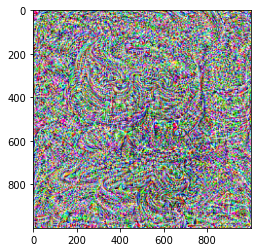

In [109]:
import matplotlib.pyplot as plt
plt.imshow(x_test_adv[0].numpy().transpose(1,2,0))